In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection


import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=False, num_workers=1
)
# retain_loader = torch.utils.data.DataLoader(
#     retain_set, batch_size=128, shuffle=True, num_workers=1, generator=RNG
# )

In [4]:
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=False, num_workers=1
)

In [5]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [6]:
def plot_teacher_student_outputs(teacher_logits, student_logits):
    teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=0).cpu().numpy()
    student_probs = torch.nn.functional.softmax(student_logits, dim=0).cpu().numpy()
    plt.plot(teacher_probs, 'ko', label='teacher')
    plt.plot(student_probs, 'ro', label='student')
    plt.legend()
    plt.yscale('log')
    plt.show()

## Teacher

In [7]:
'''
Shuffle retain data
'''

data_list = []
label_list = []

for data, label in retain_loader:
    data_list.append(data)
    label_list.append(label)
    
all_data = torch.cat(data_list, 0)
all_labels = torch.cat(label_list, 0)
    
combined = list(zip(all_data, all_labels))
random.shuffle(combined)
shuffled_data, shuffled_labels = zip(*combined)

shuffled_data = torch.stack(shuffled_data)
shuffled_labels = torch.stack(shuffled_labels)

shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)
retain_loader = DataLoader(shuffled_dataset, batch_size=128, shuffle=False)

In [8]:
teacher_logits_tensor = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_logits_tensor[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

# Create a dataloader
retain_logit_loader = DataLoader(teacher_logits_tensor, batch_size=128, shuffle=False)

In [9]:
'''
Shuffle forget data
'''

data_list = []
label_list = []

for data, label in forget_loader:
    data_list.append(data)
    label_list.append(label)
    
all_data = torch.cat(data_list, 0)
all_labels = torch.cat(label_list, 0)
    
combined = list(zip(all_data, all_labels))
random.shuffle(combined)
shuffled_data, shuffled_labels = zip(*combined)

shuffled_data = torch.stack(shuffled_data)
shuffled_labels = torch.stack(shuffled_labels)

shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)
forget_loader = DataLoader(shuffled_dataset, batch_size=128, shuffle=False)

In [10]:
teacher_logits_tensor = torch.zeros(len(forget_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in forget_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        teacher_logits_tensor[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

# Create a dataloader
forget_logit_loader = DataLoader(teacher_logits_tensor, batch_size=128, shuffle=False)

In [11]:
ft_test_losses = compute_losses(model, test_loader)

## Student

In [12]:
# Apply pruning
pct = 0.50
unstructure_prune(model, pct, global_pruning=True, random_init=False, only_fc=True)
# prune_test(model, pct, only_fc=True)

In [13]:
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True

In [1]:
import math

In [4]:
math.log(1e-6 / 0.4) / math.log(0.99)

1283.461569256528

In [14]:
student_logits = torch.zeros(len(retain_loader.dataset), 10)

start_idx = 0
with torch.no_grad():
    for (inputs, labels) in retain_loader:
        end_idx = start_idx + inputs.shape[0]
        outputs = model(inputs.to(DEVICE))
        student_logits[start_idx:end_idx] = outputs.cpu()
        start_idx = end_idx

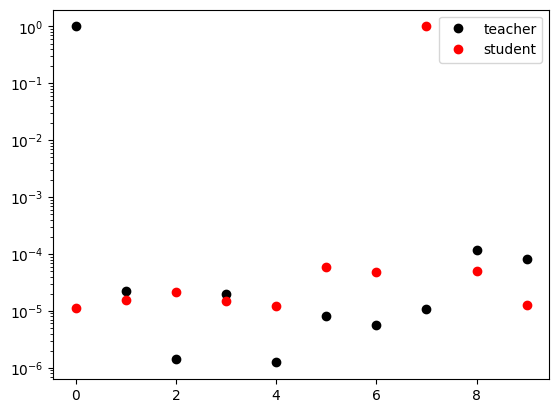

In [15]:
plot_teacher_student_outputs(teacher_logits_tensor[3], student_logits[3])

In [16]:
ft_forget_losses, test_losses, ft_mia_scores = get_all_metrics(ft_test_losses, model, retain_loader, forget_loader, val_loader, test_loader)

Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Val set accuracy: 88.9%
Test set accuracy: 88.4%
The MIA has an accuracy of 0.576 on forgotten vs unseen images
Earth movers distance = 0.418


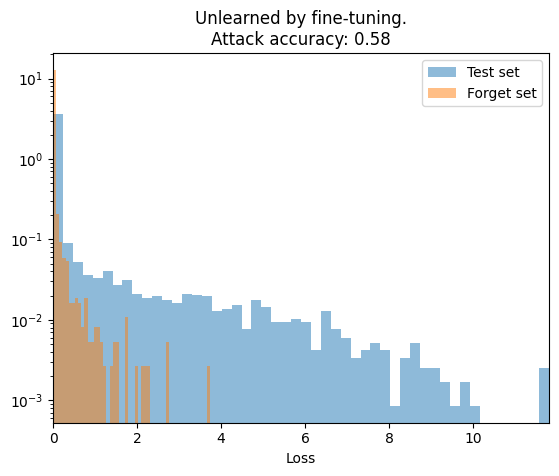

In [17]:
fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_test_losses)))
plt.legend()

plt.show()

# Forget

In [18]:
# initial_lr = 0.01/2
# epochs = 1

# current_batch = 0
# total_samples = len(forget_loader.dataset)
# batch_size = forget_loader.batch_size
# batches_per_epoch  = math.ceil(total_samples / batch_size)
# total_batches = epochs * batches_per_epoch
# initial_lr = 0.01
# warmup_batches = math.ceil(0.4*batches_per_epoch)

# criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
# optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# model.train()

# for _ in range(epochs):
#     for inputs, targets in forget_loader:
#         inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

#         current_batch += 1

#         # Warm-up for the first 'warmup_batches' batches
#         # if current_batch <= warmup_batches:
#         #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = -1.0*criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()

# ft_forget_losses, test_losses, ft_mia_scores = get_all_metrics(ft_test_losses, model, retain_loader, forget_loader, val_loader, test_loader)

# fig = plt.Figure(figsize=(16, 6))

# plt.title(
#     f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
# )
# plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
# plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

# plt.xlabel("Loss")
# plt.yscale("log")
# plt.xlim((0, np.max(ft_test_losses)))
# plt.legend()

# plt.show()

## Knowledge distillation

In [21]:
alpha = 0.9
n_classes = 10
T = 10.0

initial_lr = 0.01/2
epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

model.train()


for ep in range(epochs):

    for (inputs, targets), teacher_logits in zip(retain_loader, retain_logit_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        teacher_logits = teacher_logits.to(DEVICE)

        optimizer.zero_grad()
        
        # Forward pass student
        student_logits = model(inputs)

        # Calculate soft labels from teacher
        teacher_probs = F.softmax(teacher_logits/T, dim=1)

        # Compute distillation loss
        student_log_probs = F.log_softmax(student_logits, dim=1) #/T
        distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

        # Perform label smoothing
        # labels_one_hot = F.one_hot(labels, n_classes).float()
        # labels_smooth = (1-alpha) * labels_one_hot + (alpha/n_classes)

        # Compute the classification loss
        classification_loss = criterion(student_logits, targets)

        loss = alpha*distillation_loss + (1-alpha)*classification_loss
        loss.backward()
        optimizer.step()

In [22]:
# student_logits = torch.zeros(len(retain_loader.dataset), 10)

# start_idx = 0
# with torch.no_grad():
#     for (inputs, labels) in retain_loader:
#         end_idx = start_idx + inputs.shape[0]
#         outputs = model(inputs.to(DEVICE))
#         student_logits[start_idx:end_idx] = outputs.cpu()
#         start_idx = end_idx

# plot_teacher_student_outputs(teacher_logits_tensor[3], student_logits[3])

## Evaluation

In [23]:
ft_forget_losses, test_losses, ft_mia_scores = get_all_metrics(ft_test_losses, model, retain_loader, forget_loader, val_loader, test_loader)

Retain set accuracy: 99.5%
Forget set accuracy: 99.0%
Val set accuracy: 88.4%
Test set accuracy: 87.8%
The MIA has an accuracy of 0.573 on forgotten vs unseen images
Earth movers distance = 0.410


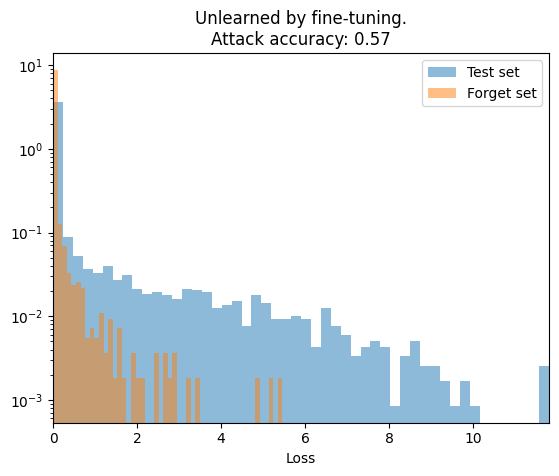

In [24]:
fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_test_losses)))
plt.legend()

plt.show()

# More retrain

In [ ]:
alpha = 0.9
n_classes = 10
T = 2.0

initial_lr = 0.01/2
epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

model.train()


for ep in range(epochs):

    for (inputs, targets), teacher_logits in zip(retain_loader, retain_logit_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        teacher_logits = teacher_logits.to(DEVICE)

        optimizer.zero_grad()
        
        # Forward pass student
        student_logits = model(inputs)

        # Calculate soft labels from teacher
        teacher_probs = F.softmax(teacher_logits/T, dim=1)

        # Compute distillation loss
        student_log_probs = F.log_softmax(student_logits/T, dim=1)
        distillation_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)

        # Perform label smoothing
        # labels_one_hot = F.one_hot(labels, n_classes).float()
        # labels_smooth = (1-alpha) * labels_one_hot + (alpha/n_classes)

        # Compute the classification loss
        classification_loss = criterion(student_logits, targets)

        loss = alpha*distillation_loss + (1-alpha)*classification_loss
        loss.backward()
        optimizer.step()

In [ ]:
ft_forget_losses, test_losses, ft_mia_scores = get_all_metrics(ft_test_losses, model, retain_loader, forget_loader, val_loader, test_loader)

In [ ]:
fig = plt.Figure(figsize=(16, 6))

plt.title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
plt.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

plt.xlabel("Loss")
plt.yscale("log")
plt.xlim((0, np.max(ft_test_losses)))
plt.legend()

plt.show()